<a href="https://colab.research.google.com/github/NaviaEddy/PrimerParcial_SIS421/blob/main/SegundoEjercicio_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [4]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from scipy.io import loadmat

from torchvision import datasets, transforms

import pandas as pd
from tensorflow import keras

In [5]:
import torchvision

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import zipfile
import os

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/Perros_dataset.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/zip_extraido'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")

¡Descompresión completada!


In [12]:
import os
import numpy as np
import random
from PIL import Image

def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Redimensionar imagen
                    imagen_resized = imagen.resize(tamaño_imagen)
                    # Convertir imagen a array de NumPy
                    imagen_array = np.array(imagen_resized) / 255.0  # Normalizar la imagen
                    dataset.append((imagen_array, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    # Obtener X (imágenes) y y (etiquetas)
    X = np.array([item[0] for item in dataset])
    y = np.array([item[1] for item in dataset])

    return X, y

In [9]:
classes = ('Afghan hound', 'Beagle', 'Bulldog Ingles', 'Collie', 'Coocker', 'German Pointer', 'Golden retriever', 'Malamutes'
          , 'Pug', 'Saint bernard', 'Schnauzer', 'Siberian husky')

In [13]:
ruta_dataset = '/content/zip_extraido/Perros_dataset'
X, y = cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50))
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (60484, 50, 50, 3)
Dimensiones de y: (60484,)


In [14]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        X_train, y_train = X, y
        X_test, y_test = X, y
        X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000].astype(np.int64), y[50000:].astype(np.int64)
        X_train = X_train.transpose(0, 3, 1, 2)
        X_test = X_test.transpose(0, 3, 1, 2)
        #X_train = X_train.reshape(-1, 7500)
        #X_test = X_test.reshape(-1, 7500)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [15]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3, 50, 50]), torch.Size([64]))

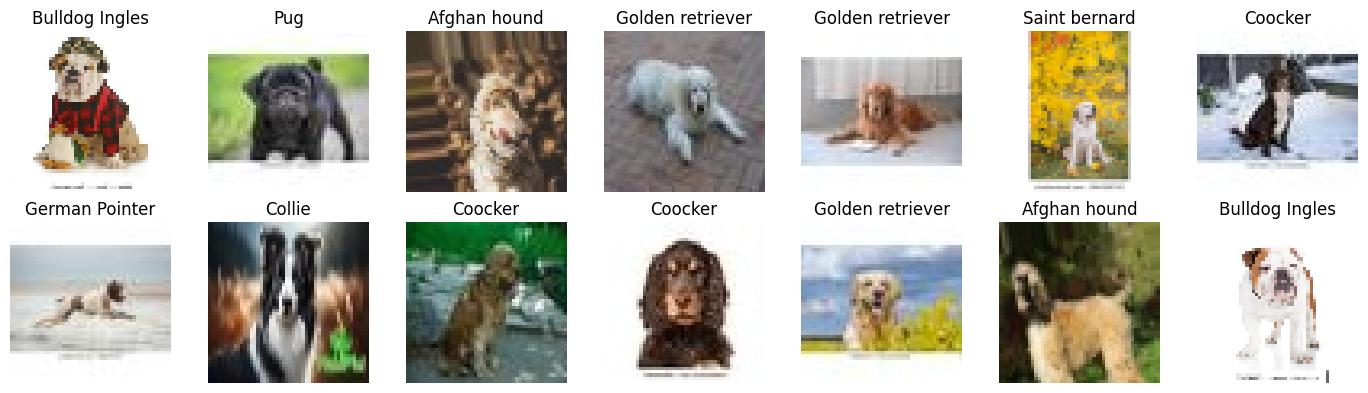

In [16]:
r, c = 2, 7
fig = plt.figure(figsize=(2*c, 2*r))

# Asegurándonos de no intentar acceder a más imágenes de las que existen en el lote
n_images = min(r * c, imgs.shape[0])

for ix in range(n_images):
    ax = plt.subplot(r, c, ix + 1)
    # No necesitamos reorganizar el tensor, asumimos que ya está en el formato correcto
    img = imgs[ix].permute(1, 2, 0)  # Cambia de [3, 50, 50] a [50, 50, 3] para visualización
    label = labels[ix]

    ax.axis("off")
    ax.imshow(img)  # Aquí ya no es necesario usar reshape, img ya debería estar en [50, 50, 3]
    ax.set_title(classes[label.item()])  # Asumiendo que 'classes' es una lista de nombres de clases

plt.tight_layout()
plt.show()


In [17]:
convnext_tiny = torchvision.models.convnext_tiny()
convnext_tiny

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [18]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=12, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    convnext_tiny = torchvision.models.convnext_tiny(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.convnext_tiny = torch.nn.Sequential(*list(convnext_tiny.children())[:-1])
    if freeze:
      for param in self.convnext_tiny.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(768, 12)

  def forward(self, x):
    x = self.convnext_tiny(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [19]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 50, 50))
outputs.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 12])

In [55]:
from tqdm import tqdm
import torch

def fit(model, data_module, epochs=None, lr=0.0005, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(data_module.train_dataloader())
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        val_loss, val_acc = [], []
        bar = tqdm(data_module.val_dataloader())
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


In [21]:
# Set the device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
dm = MNISTDataModule()
dm.setup()  # Prepare the data (this would typically be called internally in a PL Trainer)

model_c = ModelCustom()
fit(model_c, dm, epochs=10)

val_loss 1.84002 val_acc 0.35801: 100%|██████████| 164/164 [00:02<00:00, 56.17it/s]


Epoch 1/10 loss 2.09294 val_loss 1.84002 acc 0.27178 val_acc 0.35801


val_loss 1.55142 val_acc 0.46009: 100%|██████████| 164/164 [00:03<00:00, 53.49it/s]


Epoch 2/10 loss 1.66851 val_loss 1.55142 acc 0.42004 val_acc 0.46009


val_loss 1.48452 val_acc 0.47957: 100%|██████████| 164/164 [00:02<00:00, 59.30it/s]


Epoch 3/10 loss 1.44821 val_loss 1.48452 acc 0.49397 val_acc 0.47957


val_loss 1.25742 val_acc 0.55777: 100%|██████████| 164/164 [00:02<00:00, 59.65it/s]


Epoch 4/10 loss 1.27486 val_loss 1.25742 acc 0.55077 val_acc 0.55777


val_loss 1.28396 val_acc 0.55449: 100%|██████████| 164/164 [00:03<00:00, 53.77it/s]


Epoch 5/10 loss 1.11525 val_loss 1.28396 acc 0.60674 val_acc 0.55449


val_loss 1.08441 val_acc 0.62660: 100%|██████████| 164/164 [00:02<00:00, 59.45it/s]


Epoch 6/10 loss 0.96942 val_loss 1.08441 acc 0.65651 val_acc 0.62660


val_loss 0.96803 val_acc 0.65761: 100%|██████████| 164/164 [00:02<00:00, 59.10it/s]


Epoch 7/10 loss 0.82269 val_loss 0.96803 acc 0.70656 val_acc 0.65761


val_loss 1.12188 val_acc 0.63554: 100%|██████████| 164/164 [00:03<00:00, 53.48it/s]


Epoch 8/10 loss 0.68008 val_loss 1.12188 acc 0.75148 val_acc 0.63554


val_loss 0.89031 val_acc 0.70604: 100%|██████████| 164/164 [00:02<00:00, 58.94it/s]


Epoch 9/10 loss 0.57259 val_loss 0.89031 acc 0.79316 val_acc 0.70604


val_loss 0.85722 val_acc 0.71827: 100%|██████████| 164/164 [00:03<00:00, 54.14it/s]

Epoch 10/10 loss 0.46626 val_loss 0.85722 acc 0.83012 val_acc 0.71827


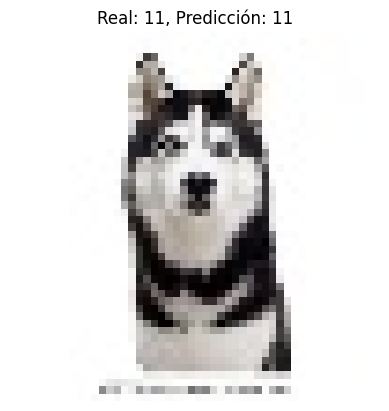

In [71]:
import matplotlib.pyplot as plt

# Obtener una muestra aleatoria del conjunto de datos de validación
imgs, labels = next(iter(dm.val_dataloader()))
idx = torch.randint(0, len(imgs), (1,)).item()  # Usar torch.randint para generar un índice aleatorio
img, label = imgs[idx], labels[idx]

# Realizar la predicción con el modelo
model_c.eval()
with torch.no_grad():
    img = img.to(device)  # Mover la imagen a la GPU si está disponible
    pred = model_c(img.unsqueeze(0))  # Añadir dimensión del batch

# Obtener la etiqueta predicha
pred_label = torch.argmax(pred).item()

# Mostrar la imagen y la predicción
plt.imshow(img.permute(1, 2, 0).cpu())  # Cambiar el orden de las dimensiones para visualizar la imagen correctamente
plt.title(f'Real: {label.item()}, Predicción: {pred_label}')
plt.axis('off')
plt.show()
